# Portfolio Optimization using Markowitz & Black-Litterman Model 

#### Mathematical symbols used in this notebook

| Python symbol | Math Symbol | Comment
| -- | -- | --
| rf | $r$ | risk free rate
| lambdaa | $\lambda$ | risk aversion coefficient
| C | $C$ | Assets covariance matrix
| V | $V$ | Assets variances (diagonal in covariance matrix)
| W | $W$ | Assets weights
| R | $R$ | Assets returns
| mean | $\mu$ | Portfolio historical return
| var | $\sigma$ | Portfolio historical variance
| Pi | $\Pi$ | Portfolio equilibrium excess returns
| tau | $\tau$ | Scaling factor for Black-litterman

## Importing all the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib_inline
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (16, 9)
import scipy.optimize
from pandas_datareader import data as web
import yfinance as yf
from pytickersymbols import PyTickerSymbols
from collections import defaultdict
from IPython.core.display import HTML
import seaborn as sns

## Load Historical Prices

In [2]:
stock_data = PyTickerSymbols()
stocks_list = stock_data.get_dow_jones_nyc_yahoo_tickers()
stocks_list.remove('DOW')
len(stocks_list)

30

In [3]:
tickers = yf.Tickers(stocks_list)
market_cap = {}
for str in stocks_list:
    market_cap[str] = tickers.tickers[str].info['marketCap']

In [4]:
# Function loads historical stock prices of Dow Jones companies and returns them together
# with their market capitalizations
def load_data():
    symbols = stocks_list
    n = len(symbols)
    prices_out, caps_out = [], []
    for s in symbols:
        file_name = 'dow-jones/{}.csv'.format(s)
        dataframe = pd.read_csv(file_name, index_col = None, parse_dates = ['date'])
        prices = list(dataframe['close'])[-2000:] # trailing window 2000 days
        prices_out.append(prices)
        caps_out.append(market_cap[s])
    return symbols, prices_out, caps_out

names, prices, caps = load_data()
prices = np.array(prices)

In [5]:
# Function takes historical stock prices together with market capitalizations and
# calculates weights, historical returns and historical covariances
def daily_asset_estimator(prices):
    prices = np.matrix(prices)
    r, c = prices.shape
    historical_returns = np.empty([r, c-1])
    for ri in range(r):
        for ci in range(c-1):
            prior_price, after_price = prices[ri, ci], prices[ri, ci+1]
            historical_returns[ri, ci] = (after_price/prior_price)-1
    expected_returns = np.array([])
    for ri in range(r):
        expected_returns = np.append(expected_returns, np.mean(historical_returns[ri]))
    covariance = np.cov(historical_returns)
    expected_returns = (1 + expected_returns) ** 252 - 1
    print(expected_returns)
    covariance = covariance * 252
    return expected_returns, covariance

W = np.array(caps)/sum(caps)
R, C = daily_asset_estimator(prices)
rf = 0.0353

[-0.01139749  0.12995906  0.26771352  0.14330435  0.19238213  0.12186442
  0.10622025  0.06863905  0.00242946  0.13351046  0.18575797  0.02421168
  0.01385409  0.09013986  0.16080835  0.17237675  0.16905813  0.10793506
  0.27721477  0.08804824  0.10664208  0.25998061 -0.00486174  0.19883916
  0.08740008 -0.04320811  0.02958325  0.0985969   0.13577698  0.17975741]


In [6]:
display(pd.DataFrame({'Return': R, 'Weight (based on market cap)': W}, index = names).T)

,MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,GS-PK,GS,...,TRV,UNH,VZ,V,WMT,WBA,DIS,AMGN,HON,CRM
Return,-0.011397,0.129959,0.267714,0.143304,0.192382,0.121864,0.106220,0.068639,0.002429,0.133510,...,0.106642,0.259981,-0.004862,0.198839,0.08740,-0.043208,0.029583,0.098597,0.135777,0.179757
Weight (based on market cap),0.005046,0.010018,0.247467,0.010953,0.009808,0.026981,0.017344,0.025134,0.005769,0.009721,...,0.003835,0.041461,0.014341,0.043910,0.03743,0.002471,0.016691,0.011340,0.011909,0.018181


In [7]:
display(pd.DataFrame(C, columns = names, index = names))

,MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,GS-PK,GS,...,TRV,UNH,VZ,V,WMT,WBA,DIS,AMGN,HON,CRM
MMM,0.055676,0.039020,0.031454,0.042619,0.043129,0.034246,0.033934,0.022534,0.006730,0.039561,...,0.028235,0.027265,0.017047,0.031692,0.015694,0.032906,0.030632,0.025396,0.038317,0.028581
AXP,0.039020,0.103630,0.042249,0.084360,0.054507,0.058980,0.041853,0.030378,0.015698,0.067624,...,0.046075,0.042366,0.019516,0.055494,0.015800,0.039406,0.054407,0.028300,0.052520,0.044761
AAPL,0.031454,0.042249,0.089736,0.053437,0.037102,0.033323,0.044688,0.021921,0.010677,0.044733,...,0.026244,0.036326,0.015510,0.046569,0.022358,0.031281,0.038504,0.032058,0.036203,0.058264
BA,0.042619,0.084360,0.053437,0.180151,0.065614,0.069045,0.046005,0.034529,0.019903,0.072058,...,0.049670,0.043013,0.020921,0.056293,0.017538,0.045312,0.062272,0.026050,0.063554,0.053303
CAT,0.043129,0.054507,0.037102,0.065614,0.092222,0.056162,0.039267,0.022905,0.007880,0.056290,...,0.035548,0.030836,0.018608,0.039205,0.016820,0.037299,0.039834,0.028903,0.047004,0.035667
CVX,0.034246,0.058980,0.033323,0.069045,0.056162,0.098577,0.036036,0.026002,0.015513,0.054596,...,0.041814,0.036705,0.020457,0.040715,0.014860,0.033232,0.040509,0.024951,0.045060,0.033270
CSCO,0.033934,0.041853,0.044688,0.046005,0.039267,0.036036,0.069537,0.022452,0.007820,0.041331,...,0.028602,0.031708,0.018935,0.039709,0.022037,0.034211,0.037192,0.030038,0.036890,0.045105
KO,0.022534,0.030378,0.021921,0.034529,0.022905,0.026002,0.022452,0.035649,0.007123,0.024511,...,0.024923,0.021903,0.017557,0.025159,0.015389,0.021925,0.024005,0.018360,0.026100,0.020407
GS-PK,0.006730,0.015698,0.010677,0.019903,0.007880,0.015513,0.007820,0.007123,0.015124,0.011795,...,0.010404,0.011178,0.004427,0.012031,0.002312,0.004425,0.009782,0.006056,0.011543,0.011626
GS,0.039561,0.067624,0.044733,0.072058,0.056290,0.054596,0.041331,0.024511,0.011795,0.088572,...,0.043195,0.038549,0.019257,0.046429,0.017675,0.039183,0.048252,0.030403,0.047291,0.044724


In [8]:
# #plotting covariance
# df = pd.DataFrame(C, columns = names, index = names)
# colormap = sns.color_palette("coolwarm")
# ax = sns.heatmap(df, cmap = colormap, annot = True, linewidths = 0.5, linecolor = 'white', cbar = True)
# plt.show()

In [9]:
# plotting correlation
def correlation_from_covariance(covariance):
    v = np.sqrt(np.diag(covariance))
    print(v)
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    return correlation

correlation = pd.DataFrame(correlation_from_covariance(C), columns = names, index = names)
mask = np.zeros_like(correlation, dtype = bool)
mask[np.triu_indices_from(mask)] = True
correlation[mask] = np.nan
(correlation.style.background_gradient(cmap = 'coolwarm', axis = None, vmin = -1, vmax = 1).highlight_null(color = '#f1f1f1').format(precision = 2))

[0.23595793 0.32191603 0.29955897 0.42444232 0.3036807  0.31396997
 0.26369833 0.18880858 0.1229788  0.29761011 0.2514801  0.24827327
 0.32848747 0.18596122 0.28528387 0.21474116 0.29783138 0.22024845
 0.28207494 0.19409466 0.24512931 0.26490156 0.18853155 0.26126043
 0.22097575 0.29813305 0.28338172 0.25100968 0.23810308 0.35454174]


,MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,GS-PK,GS,HD,IBM,INTC,JNJ,JPM,MCD,NKE,MRK,MSFT,PG,TRV,UNH,VZ,V,WMT,WBA,DIS,AMGN,HON,CRM
MMM,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
AXP,0.51,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
AAPL,0.45,0.44,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
BA,0.43,0.62,0.42,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
CAT,0.60,0.56,0.41,0.51,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
CVX,0.46,0.58,0.35,0.52,0.59,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
CSCO,0.55,0.49,0.57,0.41,0.49,0.44,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
KO,0.51,0.50,0.39,0.43,0.40,0.44,0.45,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
GS-PK,0.23,0.40,0.29,0.38,0.21,0.40,0.24,0.31,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
GS,0.56,0.71,0.50,0.57,0.62,0.58,0.53,0.44,0.32,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


## Helper functions for Optimization

In [10]:
# Calculate Mean
def port_mean(R, W):
    return np.sum(R * W)

# Calculate Variance
def port_var(W, C):
    return np.dot(np.dot(W, C), W)

In [11]:
# Optimize weights
def optimize_weights(R, C, rf):
    # Utility function to solve weights which we have to optimize
    def util_function(W, R, C, rf):
        mean = port_mean(R, W)
        var = port_var(W, C)
        util = (mean - rf) / np.sqrt(var) # Sharpe ratio
        return 1/util # To Maximize the sharpe ratio

    n = len(R)
    W = np.ones(n)/n # initialize weights with equal values
    bound = [(0., 1.) for i in range(n)]  # defining bounds for weights
    constraint = [{'type': 'eq', 'fun': lambda W: np.sum(W) - 1.}] # constraint for weights

    optimized_weights = scipy.optimize.minimize(util_function, W, (R, C, rf), method = 'SLSQP', constraints = constraint, bounds = bound)
    if not optimized_weights.success: 
        raise BaseException(optimized_weights.message)
    return optimized_weights.x

In [12]:
# For different returns we will find optimal weights and mean, variance which will help in plotting graph
def optimize_frontier(R, C, rf):
    # utility function for a particular return 
    def util_function(W, R, C, r):
        mean = port_mean(R, W)
        var = port_var(W, C)
        penalty = 100 * abs(mean - r)
        return var + penalty

    frontier_means = []
    frontier_vars = []
    frontier_weights = []
    n = len(R)

    for r in np.linspace(min(R), max(R), num = 30):
        W = np.ones(n)/n
        bound = [(0, 1) for i in range(n)]  # Defining bounds for weights
        constraint = [{'type': 'eq', 'fun': lambda W: np.sum(W) - 1}] # constraint for weights

        optimize_weights = scipy.optimize.minimize(util_function, W, (R, C, r), method = 'SLSQP', bounds = bound, constraints = constraint)
        
        if not optimize_weights.success: 
            raise BaseException(optimize_weights.message)
        frontier_weights.append(optimize_weights.x)
        frontier_means.append(r)
        frontier_vars.append(port_var(optimize_weights.x, C))

    return np.array(frontier_means), np.array(frontier_vars), np.array(frontier_weights)


In [13]:
class Result:
    def __init__(self, W, tangent_mean, tangent_var, frontier_mean, frontier_var, frontier_weights):
        self.W = W
        self.tangent_mean = tangent_mean
        self.tangent_var = tangent_var
        self.frontier_mean = frontier_mean
        self.frontier_var = frontier_var
        self.frontier_weights = frontier_weights

## Efficient Frontier

In [14]:
# Function to get the Efficient Frontier
def get_frontier(R, C, rf):
    W = optimize_weights(R, C, rf)
    tangent_mean = port_mean(R, W)
    tangent_var = port_var(W, C)
    frontier_means, frontier_vars, frontier_weights = optimize_frontier(R, C, rf)
    return Result(W, tangent_mean, tangent_var, frontier_means, frontier_vars, frontier_weights)

In [15]:
# Display Assets
def display_assets(names, R, C, color = 'black'):
    plt.scatter([C[i, i] ** .5 for i in range(n)], R, marker = 'X', color = color), plt.grid(True)  # draw assets
    for i in range(n): 
        plt.text(C[i, i] ** .5, R[i], '%s' % names[i], verticalalignment = 'center', color = color) # draw labels

# Display Efficient Frontier
def display_frontier(result: Result, label = None, color = 'black'):
    plt.text(result.tangent_var ** .5, result.tangent_mean, 'tangent', verticalalignment = 'center', color = color)
    plt.scatter(result.tangent_var ** .5, result.tangent_mean, marker = 'o', color = color), plt.grid(True)
    plt.plot(list(result.frontier_var ** .5), list(result.frontier_mean), label = label, color = color), plt.grid(True) # draw efficient frontier

result_1 = get_frontier(R, C, rf)
n = len(R)

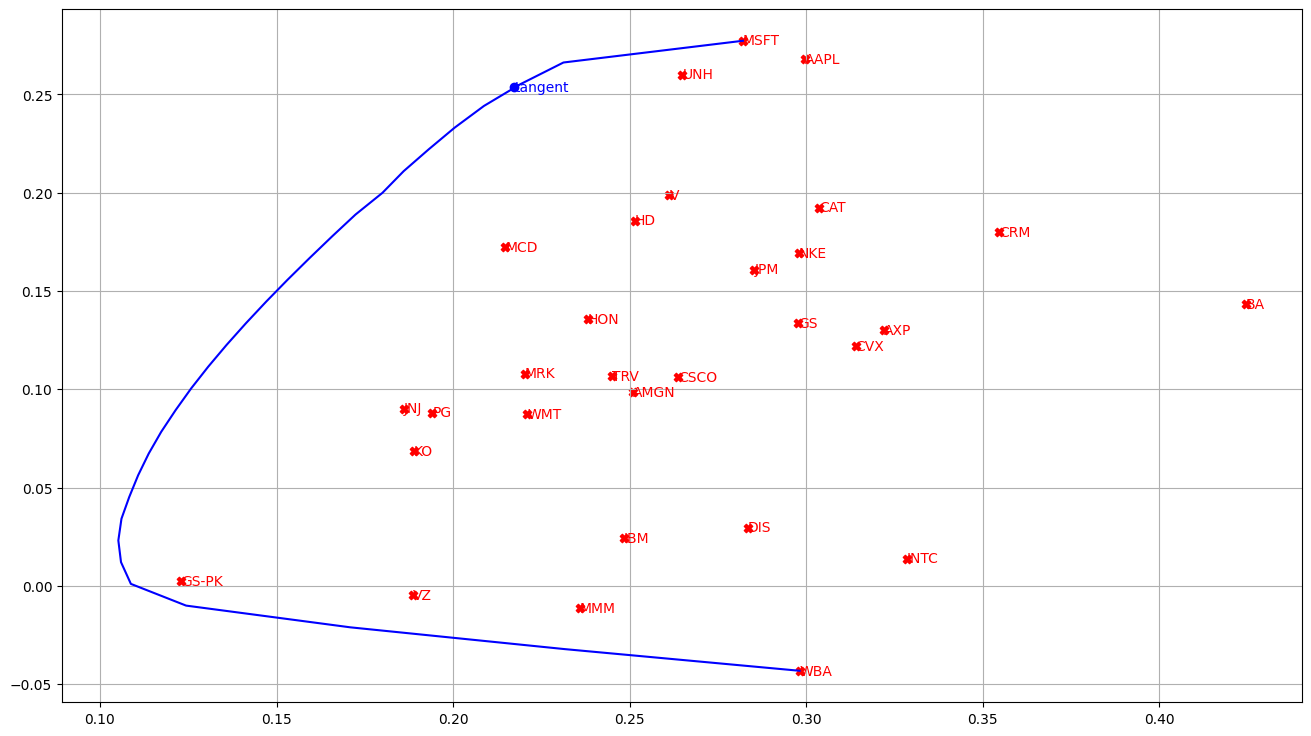

In [16]:
display_assets(names, R, C, color = 'red')
display_frontier(result_1, color = 'blue')

## Markowitz Portfolio Model

In [17]:
# To load the SPY data
def load_SPY_data():
    dataframe = pd.read_csv('dow-jones/SPY.csv', index_col = None, parse_dates = ['date'])
    spy_prices = list(dataframe['close'])[-2000:] # trailing window 2000 days
    return spy_prices

spy_prices = load_SPY_data()

In [18]:
# Calculate SPY market returns
def SPY_market_return(spy_prices):
    # Convert the input stock prices into a numpy matrix
    spy_prices = np.matrix(spy_prices)
    r, c = spy_prices.shape

    # Create an empty numpy array to store historical returns
    historical_returns = np.empty([r, c-1])
    for ri in range(r):
        for ci in range(c-1):
            # Get the current price and the price from the previous day
            prior_price, after_price = spy_prices[ri, ci], spy_prices[ri, ci+1]
            historical_returns[ri, ci] = (after_price/prior_price)-1

    # Calculate the market variance of the historical returns
    market_variance = np.cov(historical_returns)

    # Calculate the annualized market return
    market_return = (1 + np.mean(historical_returns[0])) ** 252 - 1
    print(market_return)

    # Calculate the annualized market variance
    market_variance = market_variance * 252
    print(market_variance)
    
    # Calculate the volatility of the portfolio
    volatility = np.sqrt(market_variance)
    print(volatility)

    # Return the annualized market return and covariance
    return market_return, market_variance

market_return, market_variance = SPY_market_return(spy_prices)

0.10098743222175921
0.03502158651449702
0.1871405528326157


In [19]:
# Calculate Covariance matrix
def calculate_cov_matrix(stock_prices, spy_prices):
    # Convert prices to numpy matrices
    stock_prices = np.matrix(stock_prices)
    spy_prices = np.matrix(spy_prices)
    
    # Get number of rows and columns in stock_prices
    rows, cols = stock_prices.shape
    
    # Create empty matrices to store returns
    stock_returns = np.empty([rows, cols - 1])
    spy_returns = np.empty([rows, cols - 1])
    
    # Calculate returns
    for r in range(rows):
        for c in range(cols - 1):
            # Calculate stock returns
            p0, p1 = stock_prices[r, c], stock_prices[r, c + 1]
            stock_returns[r, c] = (p1 / p0) - 1
            
            # Calculate spy returns
            if r == 0:
                p2, p3 = spy_prices[r, c], spy_prices[r, c + 1]
                spy_returns[r, c] = (p3 / p2) - 1
    
    # Calculate covariance matrix
    cov_matrix = []
    for r in range(rows):
        covar = np.cov(stock_returns[r], spy_returns)[0, 1]
        cov_matrix.append(covar)
    
    # Annualize covariance matrix and return as numpy array
    return np.asarray(cov_matrix) * 252

In [20]:
# Covariance of each stock return with market return and calculating Beta
cov_matrix = calculate_cov_matrix(prices, spy_prices)
beta = cov_matrix/market_variance
print(beta)

[0.83085545 1.22628579 1.22143333 1.4284734  1.05664751 1.05179016
 1.01807791 0.63472756 0.27432637 1.20388293 0.99600448 0.87271306
 1.20313542 0.58568924 1.14144191 0.71982371 1.05078952 0.61393043
 1.22498879 0.59707424 0.82881168 0.91861691 0.48116264 1.10618162
 0.53319981 0.84522246 1.01425628 0.78566514 0.98950626 1.24637569]


In [21]:
# Caluclating the expected return of each asset using the markowitz formula
def markowitz_portfolio_return(result: Result, C, rf, market_return, market_variance):
    return rf + np.dot(beta, (market_return - rf))

expected_asset_return = markowitz_portfolio_return(result_1, C, rf, market_return, market_variance)
print(expected_asset_return)

[0.08987676 0.11585156 0.11553282 0.12913275 0.10470846 0.10438939
 0.10217492 0.07699362 0.05331979 0.11437998 0.10072498 0.09262628
 0.11433088 0.07377242 0.11027839 0.08258337 0.10432367 0.07562751
 0.11576637 0.07452027 0.08974251 0.09564159 0.06690634 0.10796223
 0.07032453 0.09082049 0.10192389 0.08690833 0.10029813 0.11717122]


## Black-Litterman Reverse Optimization

Black-Litterman Mathematical formula:
$$E(R) = [(\tau \Sigma)^{-1} + (P^T\Omega^{-1} P)^{-1}][(\tau \Sigma)^{-1}\pi + (P^T\Omega^{-1}Q)]$$

In [22]:
# Calculate portfolio historical return and variance
mean = port_mean(R, W)
var = port_var(W, C)

# Calculate risk aversion
lambdaa = (mean - rf) / var

# Calculate equilibrium excess returns
Pi = np.dot(np.dot(lambdaa, C), W)
print(Pi + rf)

[0.14786434 0.19777713 0.23923658 0.22380406 0.17279789 0.1727062
 0.18399147 0.12259652 0.07359235 0.19518012 0.17486766 0.15543719
 0.21020682 0.120538   0.18555761 0.13804577 0.18079728 0.12340404
 0.22995692 0.12371728 0.14482544 0.16792073 0.10178208 0.19520393
 0.11579411 0.15092917 0.17200013 0.14780096 0.16850353 0.21871446]


## Equillibrium Excess return plot

[]

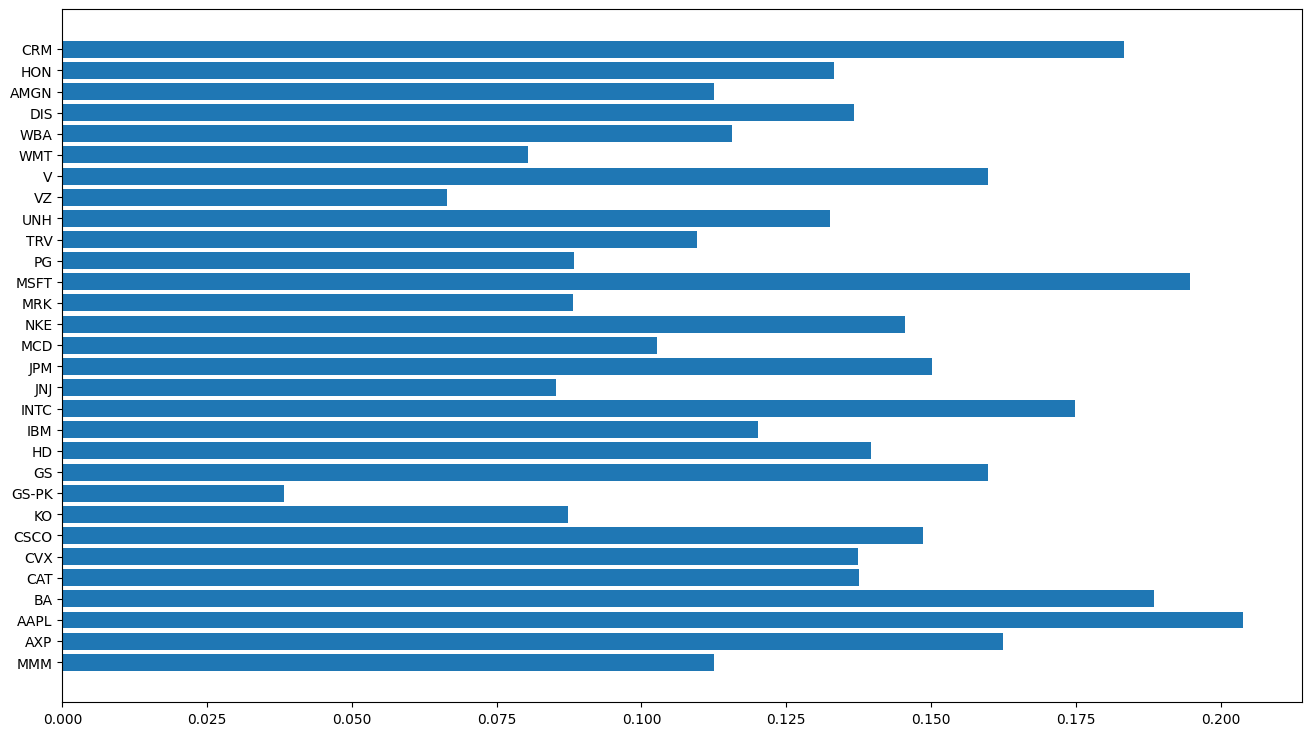

In [23]:
# Equilibrium excess return calculated during Reverse optimization
plt.barh(stocks_list, Pi)
plt.plot()

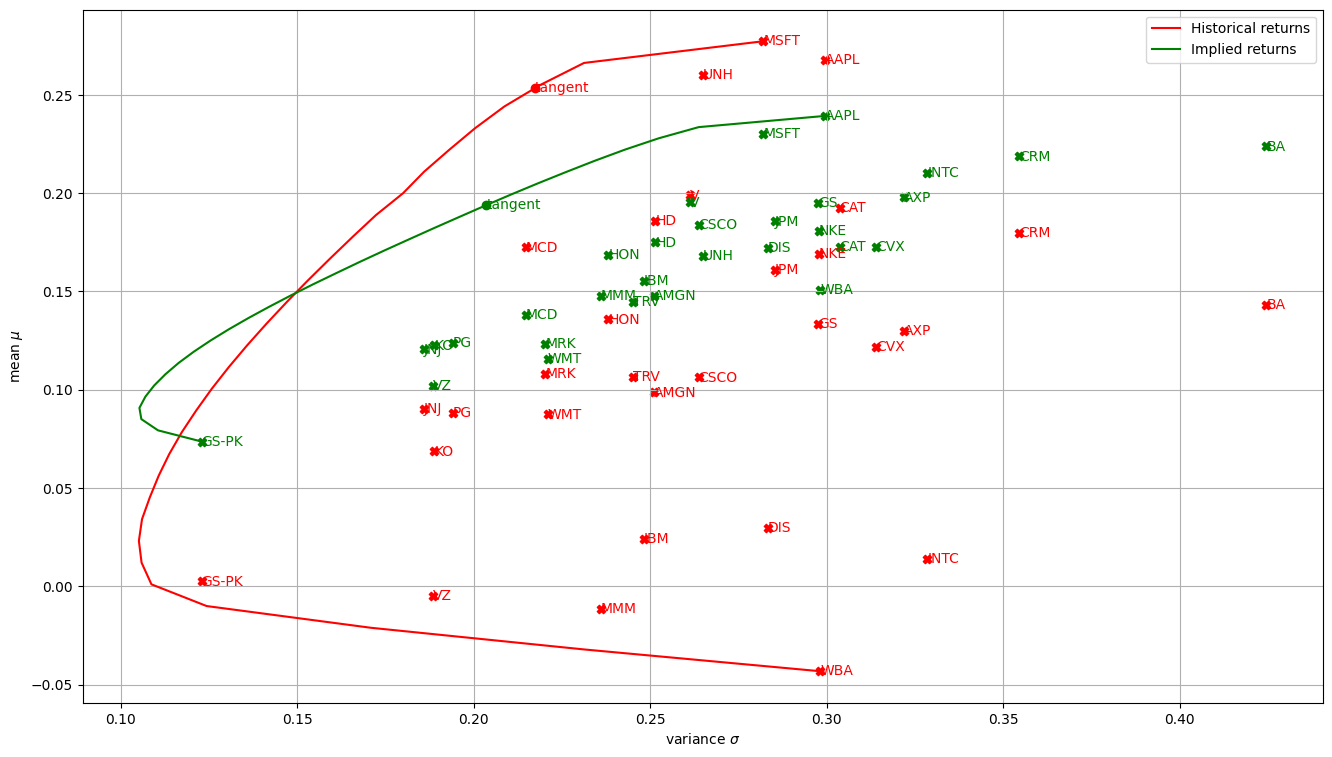

,MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,GS-PK,GS,...,TRV,UNH,VZ,V,WMT,WBA,DIS,AMGN,HON,CRM
Weight,0.005111,0.009965,0.247562,0.011143,0.009643,0.02708,0.017163,0.025182,0.004649,0.009476,...,0.003773,0.041497,0.014596,0.043939,0.037423,0.002366,0.016689,0.011277,0.01211,0.018402


In [24]:
# Calculate the Black-Litterman Model optimal weights and plotting the efficient frontier
result_2 = get_frontier(Pi + rf, C, rf)

display_assets(names, R, C, color = 'red')
display_frontier(result_1, label = 'Historical returns', color = 'red')
display_assets(names, Pi + rf, C, color = 'green')
display_frontier(result_2, label = 'Implied returns', color = 'green')
plt.xlabel('variance $\sigma$')
plt.ylabel('mean $\mu$')
plt.legend()
plt.show()
display(pd.DataFrame({'Weight': result_2.W}, index = names).T)

In [25]:
# Markowitz Model weight distribution
display(pd.DataFrame({'Weight': result_1.W}, index = names).T)

# Black-Litterman Model weight distribution
display(pd.DataFrame({'Weight': result_2.W}, index = names).T)

,MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,GS-PK,GS,...,TRV,UNH,VZ,V,WMT,WBA,DIS,AMGN,HON,CRM
Weight,0.0,0.0,0.152144,2.611167e-16,0.021393,3.077795e-18,0.0,0.0,0.0,1.638121e-16,...,0.0,0.39825,0.0,0.0,0.0,2.178549e-16,5.745687e-17,0.0,0.0,7.164412e-17


,MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,GS-PK,GS,...,TRV,UNH,VZ,V,WMT,WBA,DIS,AMGN,HON,CRM
Weight,0.005111,0.009965,0.247562,0.011143,0.009643,0.02708,0.017163,0.025182,0.004649,0.009476,...,0.003773,0.041497,0.014596,0.043939,0.037423,0.002366,0.016689,0.011277,0.01211,0.018402


## Optimization based on Equilibrium returns with adjusted views

In [26]:
# Function to create the view and link matrix
def create_views_and_link_matrix(names, relative_views, absolute_views_1):
    r, a, c = len(relative_views), len(absolute_views_1), len(names)
    Q = [relative_views[i][3] for i in range(r)]
    if(absolute_views_1):
        for i in absolute_views_1:
            Q.append(i[1])
    P = np.zeros([r+a, c])
    nameToIndex = dict()
    for i, n in enumerate(names):
        nameToIndex[n] = i
    for i, v in enumerate(relative_views):
        name1, name2 = relative_views[i][0], relative_views[i][2]
        P[i, nameToIndex[name1]] = +1 if relative_views[i][1] == '>' else -1
        P[i, nameToIndex[name2]] = -1 if relative_views[i][1] == '>' else +1
    for i, v in enumerate(absolute_views_1):
        name  = absolute_views_1[i][0]
        P[i+r, nameToIndex[name]] += 1
    return np.array(Q), P

relative_views = [('AAPL', '>', 'MSFT', 0.003),
                  ('GS', '>', 'JPM', 0.018)]

absolute_views = [('AAPL', 0.047),
                    ('AMGN', 0.089),
                    ('AXP', 0.249),
                    ('BA', 0.176),
                    ('CAT', 0.151),
                    ('CRM', 0.128),
                    ('CSCO', 0.246),
                    ('CVX', 0.205),
                    ('DIS', 0.347),
                    ('GS', 0.218),
                    ('HD', 0.119),
                    ('HON', 0.145),
                    ('IBM', 0.146),
                    ('INTC', 0.106),
                    ('JNJ', 0.125),
                    ('JPM', 0.20),
                    ('KO', 0.084),
                    ('MCD', 0.066),
                    ('MMM', 0.135),
                    ('MRK', 0.044),
                    ('MSFT', 0.075),
                    ('NKE', 0.12),
                    ('PG', 0.05),
                    ('TRV', 0.078),
                    ('UNH', 0.206),
                    ('V', 0.164),
                    ('VZ', 0.125),
                    ('WBA', 0.312),
                    ('WMT', 0.074)]

Q, P = create_views_and_link_matrix(names, relative_views, absolute_views)
print('Views Matrix')
display(pd.DataFrame({'Views':Q}))
print('Link Matrix')
P = pd.DataFrame(P)
P.columns = stocks_list
display(P)

Views Matrix


,Views
0,0.003
1,0.018
2,0.047
3,0.089
4,0.249
5,0.176
6,0.151
7,0.128
8,0.246
9,0.205


Link Matrix


,MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,GS-PK,GS,...,TRV,UNH,VZ,V,WMT,WBA,DIS,AMGN,HON,CRM
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
# Function for Black-Litterman Model Equation
tau = 0.025  # Scaling Factor

# Calculate Omega - uncertainty matrix about views
omega = np.dot(np.dot(np.dot(tau, P), C), np.transpose(P))  # 0.25 * P * C * transpose(P)

new_omega = np.zeros(omega.shape)
np.fill_diagonal(new_omega, np.diag(omega))

# Calculate Equilibrium excess returns with views incorporated
sub_a = np.linalg.inv(np.dot(tau, C))  # (tau.C)^-1
sub_b = np.dot(np.dot(np.transpose(P), np.linalg.inv(new_omega)), P)  # (P^T.omega^-1).P
sub_c = np.dot(np.linalg.inv(np.dot(tau, C)), Pi)  # ((Tau.C)^-1).Pi
sub_d = np.dot(np.dot(np.transpose(P), np.linalg.inv(new_omega)), Q)   # (P^T.omega^-1).Q

# Expected_return = ((tau.C)^-1 + (P^T.omega^-1).P) * ((Tau.C)^-1).Pi + (P^T.omega^-1).Q)
Pi_adj = np.dot(np.linalg.inv(sub_a + sub_b), (sub_c + sub_d))  

# print(omega)

result_3 = get_frontier(Pi_adj + rf, C, rf)

final_weights = result_3.W
excess_weight = 0
for i in range(len(final_weights)):
    if final_weights[i] > 0.10:
        excess_weight += final_weights[i] - 0.1

individual_weights = excess_weight/30

for i in range(len(final_weights)):
    final_weights[i] += individual_weights

final_tan_mean = port_mean(Pi_adj+rf, final_weights)
final_tan_var = port_var(final_weights, C)


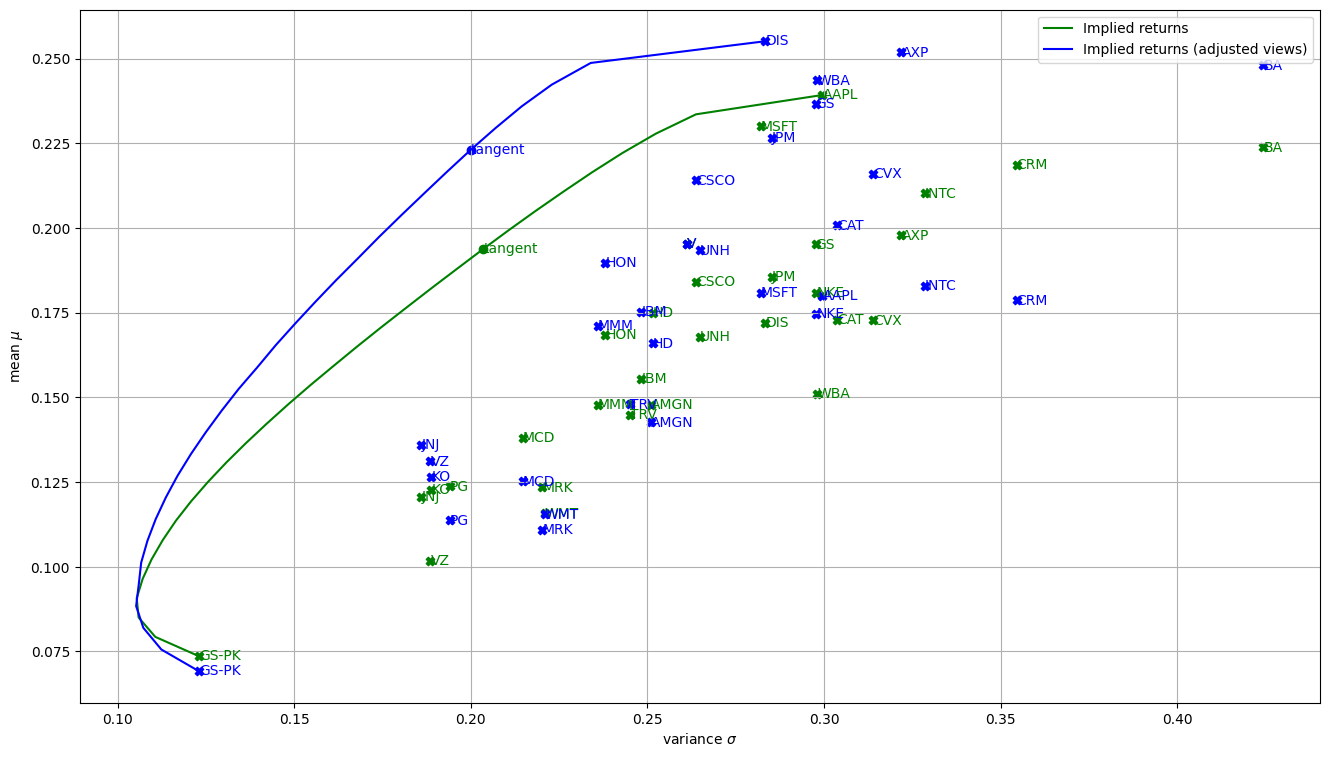

In [28]:
# Calculate the Black-Litterman Model optimal weights with adjusted views and plotting the efficient frontier
display_assets(names, Pi + rf, C, color = 'green')
display_frontier(result_2, label = 'Implied returns', color = 'green')
display_assets(names, Pi_adj + rf, C, color = 'blue')
display_frontier(result_3, label = 'Implied returns (adjusted views)', color = 'blue')

#plt.scatter(np.sqrt(final_tan_var), final_tan_mean, marker='*', color='r' )
plt.xlabel('variance $\sigma$')
plt.ylabel('mean $\mu$')
plt.legend()
plt.show()

In [29]:
# # Black-Litterman Model weight distribution
# display(pd.DataFrame({'Weight': result_2.W}, index = names).T)

# # Black-Litterman Model with adjusted views weight distribution
# display(pd.DataFrame({'Weight': result_3.W}, index = names).T)

display(pd.DataFrame({'Markowitz Model Optimal Weights': result_2.W, 'Black Litterman Model Optimal Weights': final_weights}, index = names))

,Markowitz Model Optimal Weights,Black Litterman Model Optimal Weights
MMM,0.005111,0.012354
AXP,0.009965,0.047336
AAPL,0.247562,0.012354
BA,0.011143,0.012354
CAT,0.009643,0.012354
CVX,0.027080,0.046814
CSCO,0.017163,0.137117
KO,0.025182,0.012354
GS-PK,0.004649,0.012354
GS,0.009476,0.045158


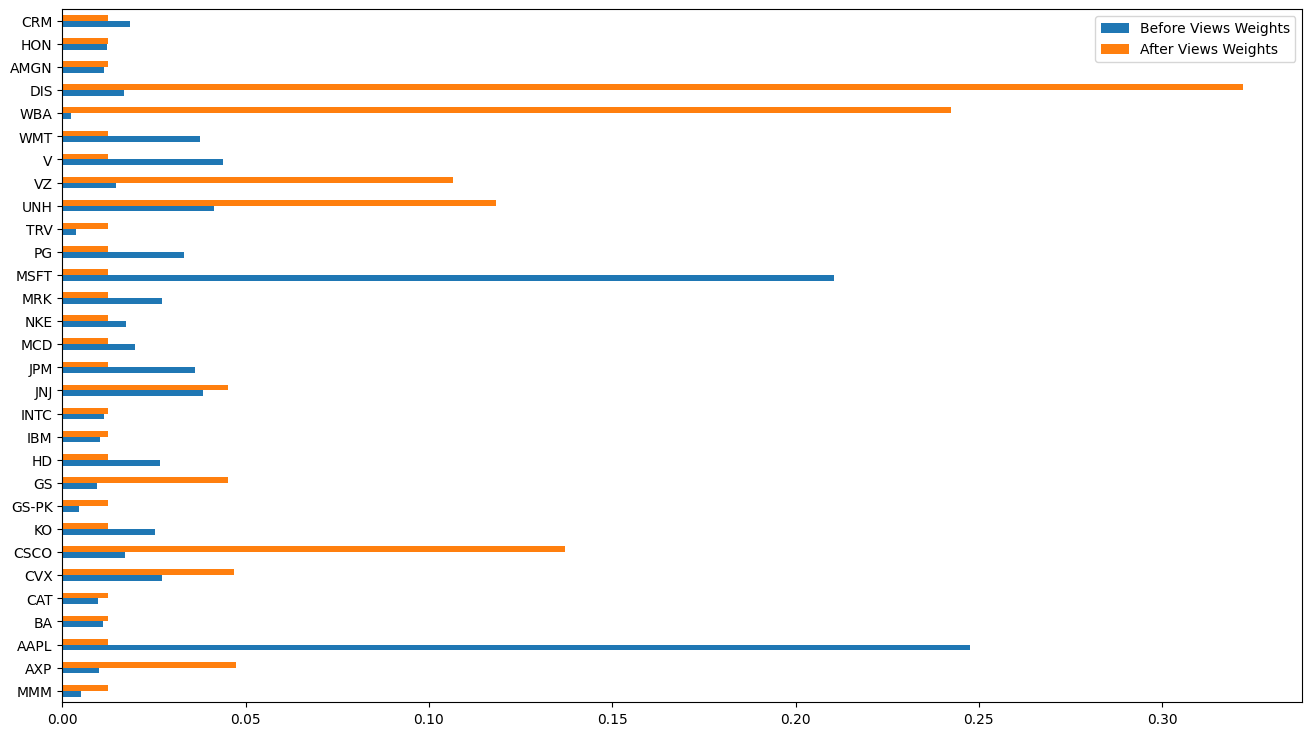

In [30]:
# Bar Plot - Before and After view weights
df = pd.DataFrame({'Before Views Weights': result_2.W, 'After Views Weights ': final_weights}, index = stocks_list)
ax = df.plot.barh()

Text(0.5, 1.0, 'Black-Litterman Weights after Views')

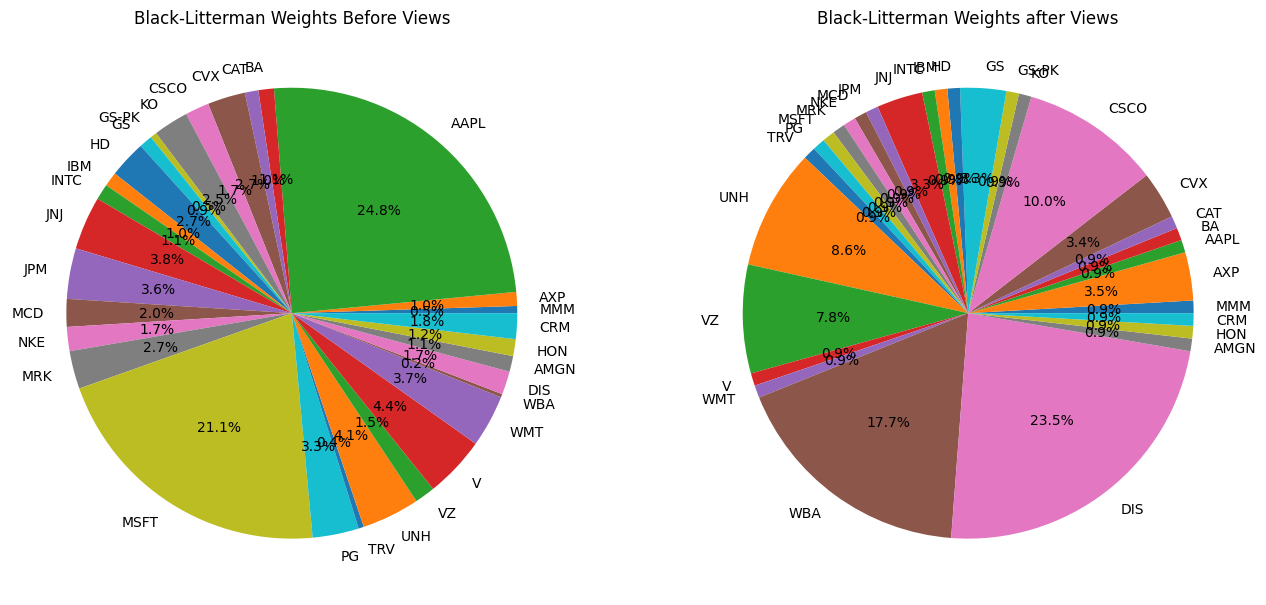

In [31]:
# Comparison b/w Black-Litterman Weights Before Views & Black-Litterman Weights after Views
labels = stocks_list
BL_weights = result_2.W
BL_views_weights = final_weights
fig, axs = plt.subplots(1, 2, figsize = (16, 8))
# ...
axs[0].pie(BL_weights,labels = labels, autopct = '%1.1f%%')
axs[0].set_title('Black-Litterman Weights Before Views')
# ...
axs[1].pie(BL_views_weights,labels = labels, autopct = '%1.1f%%')
axs[1].set_title('Black-Litterman Weights after Views')